In [72]:
import os
import cv2
from matplotlib import pyplot as plt
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [73]:
#GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [74]:

## Stick Figure CNN Model + Distance Transform

# 이미지 데이터(특징값) 불러오는 함수 -> 전처리 동시에

# 이미지 데이터(특징값) 불러오는 함수 -> 전처리 동시에
def load_images(image_path, y_train=None):
    images = []
    for filename in os.listdir(image_path):
        if y_train is not None:
            if  (filename in y_train) is False:
                continue
        img = cv2.imread(os.path.join(image_path,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            binary_image = binary_image.astype(np.uint8)  # 이미지 형식 변환
            distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
            img = cv2.resize(distance_transform, (32, 32)) # 이미지 크기 조정
            img = img.flatten() # 이미지 일차원 배열로 변환
            images.append(img)
    return np.array(images)


# CSV(목푯값) 불러오는 함수 -> 첫 번째 열(이미지 이름) 제외
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    joint = df.iloc[:, 1:].to_numpy()
    return joint

#
def load_csv_first_col(csv_path):
    df = pd.read_csv(csv_path, header=None)
    joint = df.iloc[:, 0:1].to_numpy().flatten()
    return joint

# Load image and target data
X_train = load_images("./image_train/", load_csv_first_col("./joint_train.csv"))
y_train = load_csv("./joint_train.csv")

for i in range(len(y_train)):
    if y_train[i][6] > y_train[i][10]:
        for j in range(6,10):
            tmp = y_train[i][j]
            y_train[i][j] = y_train[i][j+4]
            y_train[i][j+4] = tmp

    if y_train[i][14] > y_train[i][18]:
        for j in range(14,18):
            tmp = y_train[i][j]
            y_train[i][j] = y_train[i][j+4]
            y_train[i][j+4] = tmp

        

X_validation = load_images("./image_validation/")
y_validation = load_csv("./joint_validation.csv")


for i in range(len(y_validation)):
    if y_validation[i][6] > y_validation[i][10]:
        for j in range(6,10):
            tmp = y_validation[i][j]
            y_validation[i][j] = y_validation[i][j+4]
            y_validation[i][j+4] = tmp

    if y_validation[i][14] > y_validation[i][18]:
        for j in range(14,18):
            tmp = y_validation[i][j]
            y_validation[i][j] = y_validation[i][j+4]
            y_validation[i][j+4] = tmp

X_test = load_images("./image_test/")
y_test = load_csv("./joint_test.csv")

for i in range(len(y_test)):
    if y_test[i][6] > y_test[i][10]:
        for j in range(6,10):
            tmp = y_test[i][j]
            y_test[i][j] = y_test[i][j+4]
            y_test[i][j+4] = tmp

    if y_test[i][14] > y_test[i][18]:
        for j in range(14,18):
            tmp = y_test[i][j]
            y_test[i][j] = y_test[i][j+4]
            y_test[i][j+4] = tmp

X_ex = load_images("./image_ex/")
y_ex = load_csv("./joint_ex.csv")

for i in range(len(y_ex)):
    if y_ex[i][6] > y_ex[i][10]:
        for j in range(6,10):
            tmp = y_ex[i][j]
            y_ex[i][j] = y_ex[i][j+4]
            y_ex[i][j+4] = tmp

    if y_ex[i][14] > y_ex[i][18]:
        for j in range(14,18):
            tmp = y_ex[i][j]
            y_ex[i][j] = y_ex[i][j+4]
            y_ex[i][j+4] = tmp



# 데이터 전처리 (입력 이미지와 목표값 간의 매핑 필요)
x_train_preprocessed = X_train.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_validation_preprocessed = X_validation.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_test_preprocessed = X_test.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_ex_preprocessed = X_ex.reshape(-1, 32, 32, 1).astype('float32') / 255.0

# train 데이터의 목표값 정규화
y_train = y_train / 320.0
y_validation = y_validation / 320.0
y_test = y_test / 320.0
y_ex = y_ex / 320.0






# to device
x_train_preprocessed = torch.FloatTensor(x_train_preprocessed).to(device)
x_validation_preprocessed = torch.FloatTensor(x_validation_preprocessed).to(device)
x_test_preprocessed = torch.FloatTensor(x_test_preprocessed).to(device)
x_ex_preprocessed = torch.FloatTensor(x_ex_preprocessed).to(device)


# transpose (batch, H, W, C) -> (batch, C, H, W)
x_train_preprocessed = x_train_preprocessed.transpose(1, 3)
x_validation_preprocessed = x_validation_preprocessed.transpose(1, 3)
x_test_preprocessed = x_test_preprocessed.transpose(1, 3)
x_ex_preprocessed = x_ex_preprocessed.transpose(1, 3)

y_train = torch.FloatTensor(y_train).to(device)
y_validation = torch.FloatTensor(y_validation).to(device)
y_test = torch.FloatTensor(y_test).to(device)
y_ex = torch.FloatTensor(y_ex).to(device)


print(x_train_preprocessed.shape)
print(y_train.shape)
print(x_validation_preprocessed.shape)
print(y_validation.shape)
print(x_test_preprocessed.shape)
print(y_test.shape)
print(x_ex_preprocessed.shape)
print(y_ex.shape)


# dataset
train_dataset = torch.utils.data.TensorDataset(x_train_preprocessed, y_train)
validation_dataset = torch.utils.data.TensorDataset(x_validation_preprocessed, y_validation)
test_dataset = torch.utils.data.TensorDataset(x_test_preprocessed, y_test)
ex_dataset = torch.utils.data.TensorDataset(x_ex_preprocessed, y_ex)


# batch size
batch_size = 32

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


torch.Size([15330, 1, 32, 32])
torch.Size([15330, 22])
torch.Size([4000, 1, 32, 32])
torch.Size([4000, 22])
torch.Size([4000, 1, 32, 32])
torch.Size([4000, 22])
torch.Size([1, 1, 32, 32])
torch.Size([1, 22])


In [75]:

# model by keras
# model = tf.keras.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(22)) 
# model.compile(optimizer='adam',
#               loss='mse',
#               metrics=['mae'])
# history = model.fit(x_train_preprocessed, y_train, epochs=1000, batch_size=32, validation_data=(x_validation_preprocessed, y_validation))
#X_train.shape

##레이어 수정
# a cnn sequential model by pytorch
class SK_CNN(nn.Module):

    def __init__(self):
        super(SK_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 22)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [76]:
SAVE_DIR = './model_save'

model = SK_CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# to cuda
model = model.to(device)
criterion = criterion.to(device)

epoch = 500

# train
history = {'loss': [], 'val_loss': []}
model.train()
train_loss = 0
for epoch_idx in range(epoch):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    history['loss'].append(train_loss)
    if epoch_idx % 10 == 0:
        train_r2_score = r2_score(y_batch.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
        print('Epoch: {}, Train Loss: {:.4f}, R2 {:.4f}'.format(epoch_idx, train_loss, train_r2_score))

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in validation_loader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= len(validation_loader.dataset)
        history['val_loss'].append(val_loss)
        if epoch_idx % 10 == 0:
            val_r2_score = r2_score(y_batch.detach().cpu(), y_pred.detach().cpu())
            print('Epoch: {}, Validation Loss: {:.4f}, R2 {:4f}'.format(epoch_idx, val_loss, val_r2_score))


Epoch: 0, Train Loss: 0.0004, R2 -7.2625
Epoch: 0, Validation Loss: 0.0002, R2 -0.588033
Epoch: 10, Train Loss: 0.0001, R2 0.2117
Epoch: 10, Validation Loss: 0.0001, R2 0.611465
Epoch: 20, Train Loss: 0.0000, R2 -3.4153
Epoch: 20, Validation Loss: 0.0000, R2 0.839613
Epoch: 30, Train Loss: 0.0000, R2 0.5262
Epoch: 30, Validation Loss: 0.0000, R2 0.886419
Epoch: 40, Train Loss: 0.0000, R2 -0.3371
Epoch: 40, Validation Loss: 0.0000, R2 0.814404
Epoch: 50, Train Loss: 0.0000, R2 0.4235
Epoch: 50, Validation Loss: 0.0000, R2 0.863299
Epoch: 60, Train Loss: 0.0000, R2 -17.7890
Epoch: 60, Validation Loss: 0.0000, R2 0.886286
Epoch: 70, Train Loss: 0.0000, R2 -0.7883
Epoch: 70, Validation Loss: 0.0000, R2 0.811886
Epoch: 80, Train Loss: 0.0000, R2 0.7507
Epoch: 80, Validation Loss: 0.0000, R2 0.875648
Epoch: 90, Train Loss: 0.0000, R2 -5.1034
Epoch: 90, Validation Loss: 0.0000, R2 0.840853
Epoch: 100, Train Loss: 0.0000, R2 -1.8307
Epoch: 100, Validation Loss: 0.0000, R2 0.791220
Epoch: 110, 

In [77]:

# validation
model.eval()
validation_loss = 0
with torch.no_grad():
    for data, target in validation_loader:
        output = model(data)
        validation_loss += criterion(output, target).item()
    validation_loss /= len(validation_loader.dataset)
    validation_r2_score = r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
    print(('\nValidation set: Average loss: {:.10f}, R2 score:{:.10f}\n').format(validation_loss, validation_r2_score))

# test 
model.eval()
test_loss = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
    test_loss /= len(test_loader.dataset)
    test_r2_score = r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
    print(('\nTest set: Average loss: {:.10f}, R2 score:{:.10f}\n').format(test_loss, test_r2_score))
        



Validation set: Average loss: 0.0000295391, R2 score:0.8058680079


Test set: Average loss: 0.0000217771, R2 score:0.4071159826



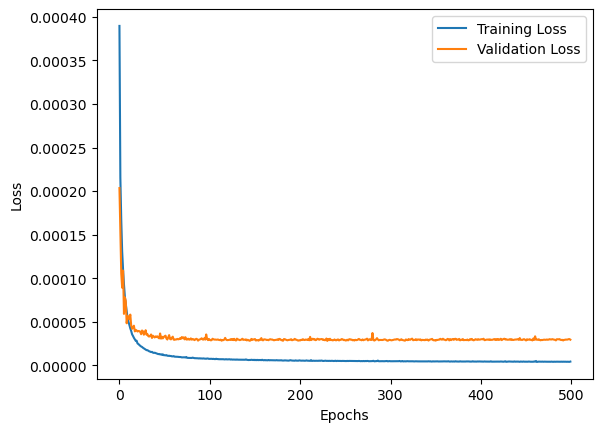

In [78]:
X_ex = load_images("./image_ex/")
y_ex = load_csv("./joint_ex.csv")

# 손실값 기록
loss = history['loss']
val_loss = history['val_loss']

# # 지표 기록
# mae = history['mae']
# val_mae = history.history['val_mae']

# 시각화 

import matplotlib.pyplot as plt



# 손실값 그래프
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



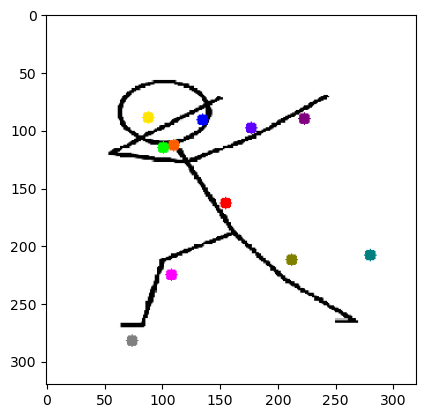

In [82]:
X_ex = load_images("./image_ex/")
x_ex_preprocessed = X_ex.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_ex_preprocessed = torch.FloatTensor(x_ex_preprocessed).to(device)
x_ex_preprocessed = x_ex_preprocessed.transpose(1, 3)
imageFile = './image_ex/ccc.png'
X_ex_image = cv2.imread(imageFile)

# 각 관절 위치 값 저장
# data=predictions[0]
data=model(x_ex_preprocessed[0].unsqueeze(0)).squeeze(0).cpu().detach().numpy()
data = data*320
c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(X_ex_image,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(X_ex_image,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(X_ex_image,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(X_ex_image,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(X_ex_image,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(X_ex_image,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(X_ex_image,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(X_ex_image,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(X_ex_image,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(X_ex_image,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(X_ex_image,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


img = cv2.cvtColor(X_ex_image, cv2.COLOR_BGR2RGB)

#이미지, 점 출력
plt.imshow(img)
plt.show()
